# REINFORCE

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [3]:
import sys
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
sys.path.append("/Users/toshi/Documents/school/machine-learning")
import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()
raw_data_train.dropna(how="any")
raw_data_test.dropna(how="any")
# print(raw_data_train)
# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

pd.set_option('display.max_columns', 1000)
# print(raw_data_train[raw_data_train["Dst Port"] == 39964])

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(1)
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    # plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

## Network

In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(PolicyNetwork, self).__init__()
        self.common_fc = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU()
        )
        self.probs = nn.Sequential(
            nn.Linear(128, n_outputs),
            nn.Softmax(dim=-1)
        )
        self.fc_value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.common_fc(x)
        probs = self.probs(x)
        value = self.fc_value(x)
        return probs, value


## Constants

In [8]:
LR = 1e-5
GAMMA = 0.99

## Variables

In [9]:
num_episodes = 5000

n_inputs = train_env.observation_space.shape[0]
n_outputs = train_env.action_space.n

policy_net = PolicyNetwork(n_inputs, n_outputs).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=LR)

steps_done = 0
memory = ReplayMemory(1000000)
episode_rewards = []
returns = []
episode_accuracy = []

## Functions

In [10]:
def select_action(state: torch.Tensor):
    prob_distri, _ = policy_net(state) # return probability of actions
    try:
        action = torch.multinomial(prob_distri, 1)
    except:
        raise Exception(state, prob_distri)
    return prob_distri, torch.multinomial(prob_distri, 1) # return index of action

def optimize_model(rewards, log_probs):
    # print(log_probs)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
    log_probs = torch.cat(log_probs, dim=0).squeeze()

    returns = []
    g = 0
    try:
        for r in rewards[::-1]:
            g = r + GAMMA * g
            returns.insert(0, g)
    except:
        returns.insert(0, rewards[0])
    
    returns_tensor = torch.tensor(returns, device=device, dtype=torch.float32)
    
    # average return method
    baseline = returns_tensor.mean()
    advantages = returns_tensor - baseline
    
    loss = - (log_probs * advantages).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

REINFORCE



## Main loop

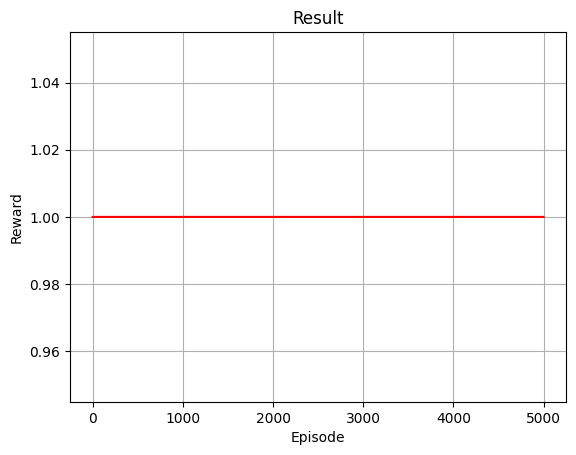

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
for i_episode in range(num_episodes):
    # Initialize the environment and state
    random.seed(i_episode)
    confusion_matrix = np.zeros((2,2), dtype=int)
    sum_reward = 0

    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    rewards = []
    log_probs = []

    for t in count():
        # print(f"State before step - Max: {state.max()}, Min: {state.min()}, Mean: {state.mean()}")
        # select action
        prob_distri, action = select_action(state)

        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["confusion_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1
        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
            if torch.isnan(next_state).any():
                raise Exception(next_state)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item()
        rewards.append(reward)
        log_probs.append(torch.log(prob_distri.gather(1, action)))

        # move to the next state
        state = next_state

        # optimize the model
        # print(len(rewards), len(log_probs))
        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    optimize_model(rewards, log_probs)

    ## graph
    base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
    episode_accuracy.append(
        confusion_matrix[0,0] / base if base != 0 else 0.0
    )
    ##

    if i_episode > 0 and i_episode % 10 == 0:
        plot_rewards(episode_accuracy)

# complete the episode
plot_rewards(episode_accuracy, show_result=True)
torch.save(policy_net.state_dict(), "reinforce.pth")  # save the model

train_env.close()

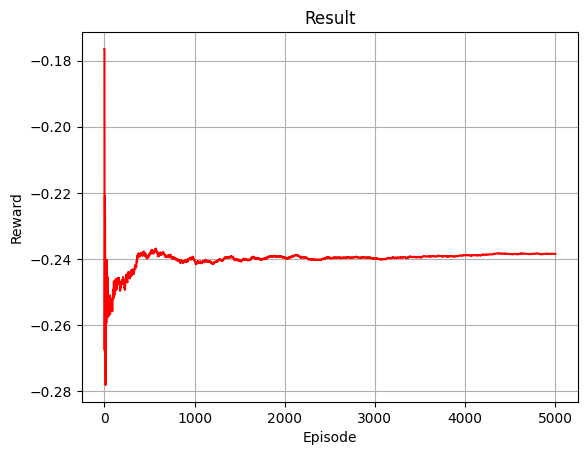

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
plot_rewards(episode_rewards, show_result=True)
torch.save(policy_net.state_dict(), "reinforce.pth")  # save the model

## Test the model

<Figure size 640x480 with 0 Axes>

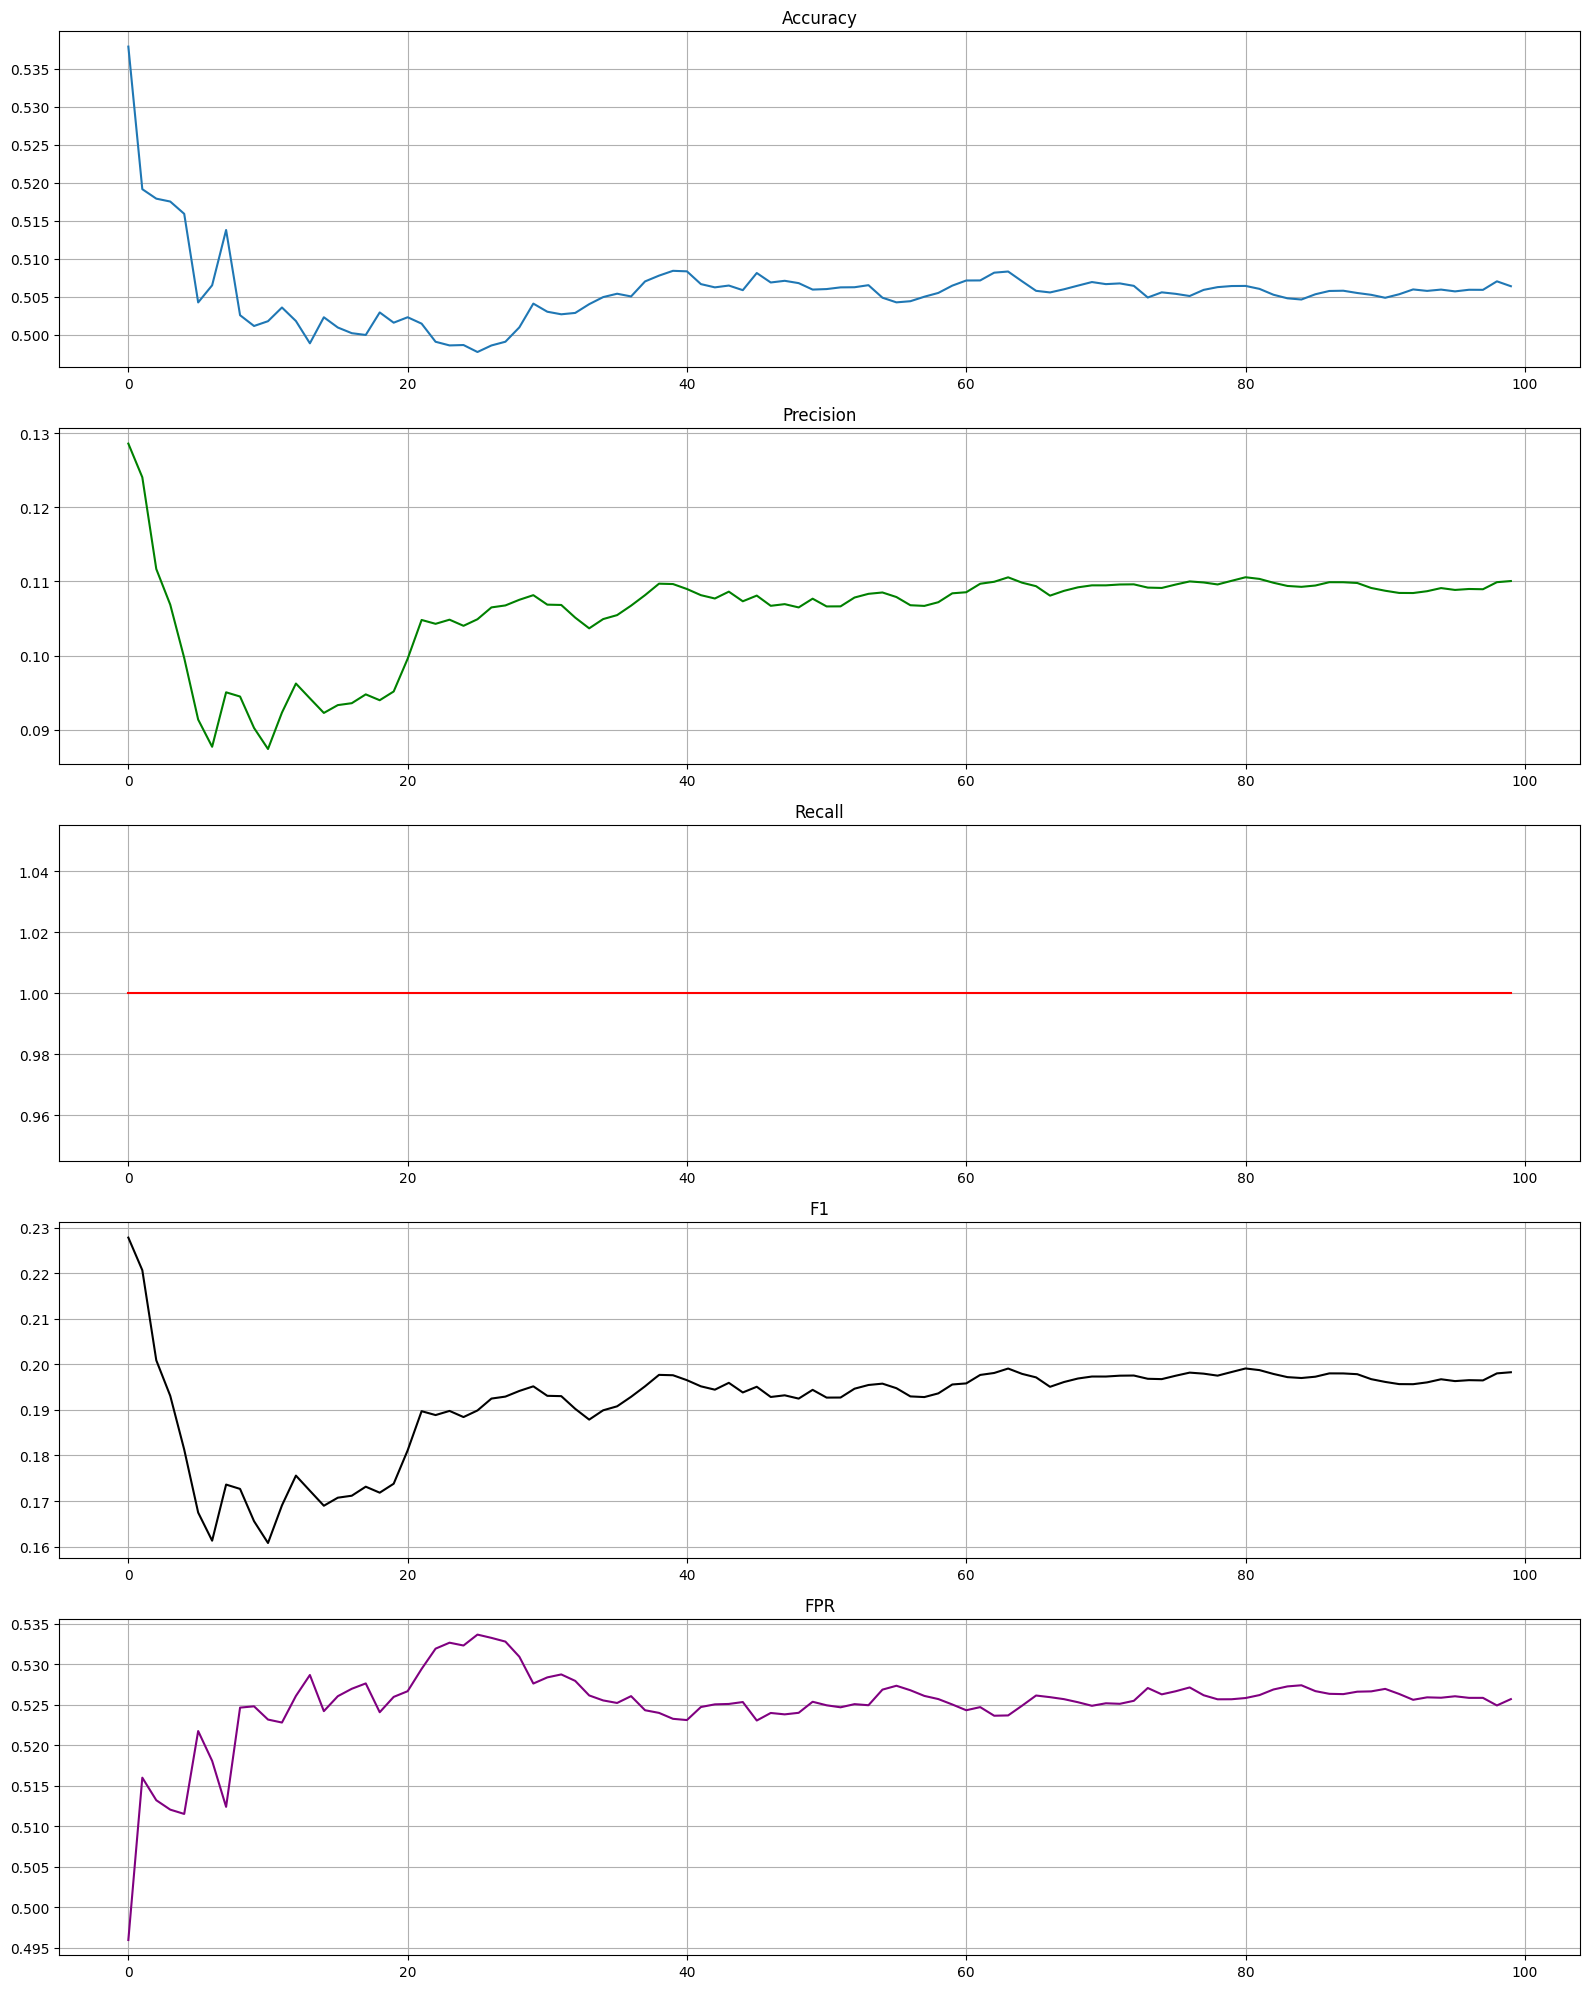

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
MODEL_PATH = "reinforce.pth"

# load the model
trained_network = PolicyNetwork(n_inputs, n_outputs).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(100):
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            prob_distribution, _ = trained_network(test_state)
            test_action = torch.multinomial(prob_distribution, 1)

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[0, 0]
    tn = confusion_array[1, 1]
    fp = confusion_array[0, 1]
    fn = confusion_array[1, 0]

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)
    print(tp, tn, fp, tn)

    if i_loop % 10 == 0:
        plot_metrics(metrics_dictionary)

tp = confusion_array[0, 0]
tn = confusion_array[1, 1]
fp = confusion_array[0, 1]
fn = confusion_array[1, 0]
print(tp, tn, fp, tn)

# plot metrics
plot_metrics(metrics_dictionary, show_result=True)